In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARProcess
import statsmodels.api as sm
import numpy as np
from preproccessing import loadStooqData, loadYahooData
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# long rate, short rate, cpi m, real gdp, stock index (SPASTT01USM661N), unempoyment('LRUN64TTUSQ156S')
#usdpln, investment growth, consumption growth, unemployment, working population growth,  tradevalue
tickers = ['IRLTLT01USQ156N','IR3TIB01USQ156N','CPALTT01USQ657N','NGDPRSAXDCUSQ']

In [3]:
start = datetime.datetime(1990, 1, 1)

end = datetime.datetime(2023, 12, 31)

df = web.DataReader(tickers, 'fred', start,end)


In [4]:
df.describe()

,IRLTLT01USQ156N,IR3TIB01USQ156N,CPALTT01USQ657N,NGDPRSAXDCUSQ
count,135.000000,135.000000,135.000000,1.350000e+02
mean,4.249358,2.948309,0.664442,3.968929e+06
std,1.998719,2.361709,0.666008,8.928822e+05
min,0.650000,0.100000,-2.828529,2.487979e+06
25%,2.560000,0.498333,0.360788,3.225511e+06
50%,4.160000,2.756667,0.629151,4.088459e+06
75%,5.888333,5.293333,1.013660,4.681108e+06
max,8.703333,8.333333,2.973833,5.626591e+06


In [5]:
df.corr()

,IRLTLT01USQ156N,IR3TIB01USQ156N,CPALTT01USQ657N,NGDPRSAXDCUSQ
IRLTLT01USQ156N,1.000000,0.849105,0.154319,-0.888202
IR3TIB01USQ156N,0.849105,1.000000,0.152945,-0.627783
CPALTT01USQ657N,0.154319,0.152945,1.000000,0.013899
NGDPRSAXDCUSQ,-0.888202,-0.627783,0.013899,1.000000


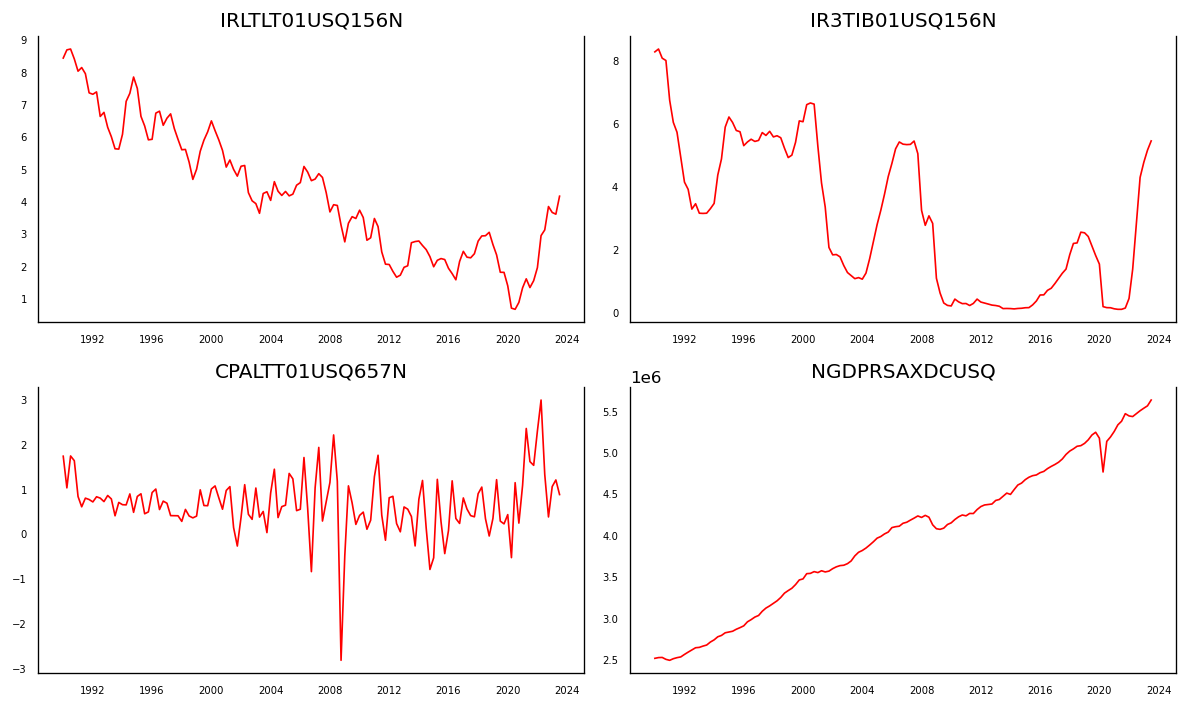

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warni

,IRLTLT01USQ156N_x,IR3TIB01USQ156N_x,CPALTT01USQ657N_x,NGDPRSAXDCUSQ_x
IRLTLT01USQ156N_y,1.0000,0.0188,0.0281,0.0203
IR3TIB01USQ156N_y,0.0000,1.0000,0.0000,0.1089
CPALTT01USQ657N_y,0.5141,0.0646,1.0000,0.0053
NGDPRSAXDCUSQ_y,0.0497,0.2047,0.2586,1.0000


In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IRLTLT01USQ156N ::  81.16     > 40.1749   =>   True
IR3TIB01USQ156N ::  43.77     > 24.2761   =>   True
CPALTT01USQ657N ::  16.85     > 12.3212   =>   True
NGDPRSAXDCUSQ ::  3.84      > 4.1296    =>   False


In [9]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IRLTLT01USQ156N" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3409
 No. Lags Chosen       = 2
 Critical value 1%     = -3.481
 Critical value 5%     = -2.884
 Critical value 10%    = -2.579
 => P-Value = 0.1591. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IR3TIB01USQ156N" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8544
 No. Lags Chosen       = 1
 Critical value 1%     = -3.481
 Critical value 5%     = -2.884
 Critical value 10%    = -2.578
 => P-Value = 0.0509. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPALTT01USQ657N" 
    -----------------------------------------------
 

In [10]:
df_differenced = df.diff().dropna()

In [11]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IRLTLT01USQ156N" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8485
 No. Lags Chosen       = 3
 Critical value 1%     = -3.482
 Critical value 5%     = -2.884
 Critical value 10%    = -2.579
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IR3TIB01USQ156N" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8315
 No. Lags Chosen       = 0
 Critical value 1%     = -3.481
 Critical value 5%     = -2.884
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPALTT01USQ657N" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

In [12]:
model = VAR(df_differenced)
x = model.select_order(maxlags=12)
x.summary()

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,17.49,17.58,3.936e+07,17.53
1,16.78,17.24,1.939e+07,16.97
2,16.31*,17.14*,1.216e+07*,16.65*
3,16.38,17.57,1.298e+07,16.86
4,16.46,18.02,1.420e+07,17.10
5,16.61,18.54,1.653e+07,17.39
6,16.62,18.92,1.691e+07,17.55
7,16.59,19.25,1.659e+07,17.67
8,16.67,19.70,1.835e+07,17.90
9,16.79,20.20,2.129e+07,18.18


In [13]:
result = model.fit(2)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Dec, 2023
Time:                     17:02:41
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.0261
Nobs:                     132.000    HQIC:                   16.5593
Log likelihood:          -1785.03    FPE:                1.13044e+07
AIC:                      16.2399    Det(Omega_mle):     8.68297e+06
--------------------------------------------------------------------
Results for equation IRLTLT01USQ156N
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.048102         0.039877           -1.206           0.228
L1.IRLTLT01USQ156N         0.400096         0.110314            3.627           0.000
L1.IR3TIB01USQ156N        -0.2

In [14]:
result.is_stable()

True

In [15]:
scenarios = result.simulate_var(steps=8,nsimulations=100)
scenarios.shape


(100, 8, 4)

In [16]:
scenarios[1]

array([[-4.81021806e-02,  3.01917620e-02, -6.23148109e-02,
         3.28898864e+04],
       [-4.81021806e-02,  3.01917620e-02, -6.23148109e-02,
         3.28898864e+04],
       [ 4.78631516e-01,  6.73686357e-02,  1.02688332e+00,
        -2.59198627e+04],
       [ 3.46154859e-02,  3.58463417e-02, -6.34081633e-01,
         7.58314153e+03],
       [ 4.09367583e-01,  1.79721024e-01, -1.66412181e-01,
         9.74343318e+04],
       [ 4.27467707e-01,  9.69183951e-01,  9.84184487e-01,
         2.74969377e+04],
       [ 2.76167225e-01,  1.19335593e+00, -4.36369975e-01,
        -3.58127883e+03],
       [-2.19340898e-02,  5.99916107e-01, -8.88716122e-01,
         6.41141709e+04]])

In [17]:
for i in range(4):
    print(result.test_causality(caused=i, causing=[0,1,2,3,4]))

IndexError: list index out of range

In [ ]:
result.fevd().summary()

FEVD for IRLTLT01USQ156N
     IRLTLT01USQ156N  IR3TIB01USQ156N  CPALTT01USQ657N  USAGDPRQPSMEI  LRUN64TTUSQ156S
0           1.000000         0.000000         0.000000       0.000000         0.000000
1           0.943145         0.017683         0.002497       0.035429         0.001246
2           0.923419         0.031138         0.004273       0.038774         0.002396
3           0.916710         0.035491         0.005603       0.038606         0.003590
4           0.913467         0.036290         0.006099       0.039797         0.004347
5           0.911974         0.036338         0.006220       0.040771         0.004696
6           0.911412         0.036316         0.006241       0.041207         0.004824
7           0.911238         0.036308         0.006243       0.041348         0.004863
8           0.911192         0.036306         0.006243       0.041384         0.004874
9           0.911182         0.036306         0.006243       0.041392         0.004876

FEVD for IR3TIB01

In [ ]:
sim = result.simulate_var(steps=None,offset=None,nsimulations=100)

In [ ]:
spy_source = loadStooqData('^SPX','1992-07-1')

In [ ]:
spy = spy_source
spy.index = pd.to_datetime(spy.index)
spy = spy.resample('QS').last()
spy = spy.loc['1992-10-01':'2023-04-02']
spy = np.log(spy/spy.shift()).dropna()
#spy = sm.add_constant(spy, prepend=False)
#exog = sm.add_constant(source_data, prepend=False)

In [ ]:
bond_source = pd.read_csv('VBMFX.csv')

In [ ]:
bond = bond_source
bond = bond.set_index(bond['Date'])
bond = bond['Adj Close']
bond.index = pd.to_datetime(bond.index)
bond = bond.resample('QS').last()
bond = bond.loc['1992-10-01':'2023-04-02']
bond = np.log(bond/bond.shift(1)).dropna()


In [ ]:
assets = pd.concat([spy,bond],axis=1)
assets.columns = ['SPY', 'BND']
#assets = assets.diff().dropna()

In [ ]:
#np.round(sm.tsa.stattools.adfuller(assets['BND'])[1],4)
sm.tsa.stattools.adfuller(assets['SPY'])

(-10.562787407711081,
 7.65154907320737e-19,
 0,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 -220.56991768257512)

In [ ]:
model_a = VAR(assets,exog=data)

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
result = model_a.fit(2)

In [ ]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Aug, 2023
Time:                     20:36:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.8087
Nobs:                     120.000    HQIC:                  -13.0846
Log likelihood:           475.853    FPE:                1.72112e-06
AIC:                     -13.2733    Det(Omega_mle):     1.46651e-06
--------------------------------------------------------------------
Results for equation SPY
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000419         0.009632           -0.043           0.965
IRLTLT01USQ156N         0.066201         0.026863            2.464           0.014
IR3TIB01USQ156N         0.035644         0.021916     

In [ ]:
result.is_stable()

True